In [1]:
# TODO
# 1: ColorLine -> DONE
# 2: Make plots of highway/surface/tracktype -> DONE
# 3: Determine paved status rules -> DONE
# 4: Determine city names
# 5: Fix double pathing
# 6: Merge data into single file
# 7: Build separate analysis script
# 8: Make plots: percentage paved vs. unpaved, length of individual paved/unpaved sections

# Other ideas
# Figure out how to plot: closest town, topography type (forest, plains, etc.), elevation profile

## Loading

In [2]:
# Preamble
from IPython.display import IFrame
from itertools import groupby 
from csv import writer
import networkx as nx
import pandas as pd
import numpy as np
import osmnx as ox
import warnings
import folium
import branca.colormap as cm
import seaborn as sns
import matplotlib.pyplot as plt
import folium
import shapely
%matplotlib inline

/Users/svanwal/opt/anaconda3/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [3]:
%%javascript
IPython.OutputArea.auto_scroll_threshold = 9999;

<IPython.core.display.Javascript object>

In [4]:
# --- Load and process the GPX track
trail = 'gr131'
# trail = 'gr16'
points_per_batch = 100
filename_in = 'data/' + trail + '.csv'
hike = pd.read_csv(filename_in)
coords = hike[['latitude','longitude']].values.tolist()
n_batch = int(np.ceil(hike.shape[0]/points_per_batch))

In [5]:
filename = 'data/' + trail + '_0to' + str(points_per_batch) + '.csv'
df = pd.read_csv(filename,dtype={'surface': str})

In [6]:
# Loading data and merging
for b in range(1,n_batch): # b is the batch counter
    n1 = b*points_per_batch # First point
    n2 = min(n1 + points_per_batch, len(hike)) # Last point
    filename = 'data/' + trail + '_' + str(n1) + 'to' + str(n2) + '.csv'
    df_new = pd.read_csv(filename,dtype={'surface': str})
    df = pd.concat([df,df_new],ignore_index=True)

## Removing backtracking

In [7]:
# TODO

## Grabbing city names

In [8]:
# Function definitions
def is_polygon(row):
    return type(row['geometry']) is shapely.geometry.polygon.Polygon

In [43]:
np = 350
imin = 0
imax = np
df['city0'] = ''
df['city1'] = ''
delta = 0.005 # Bounding box tolerance [deg]
while imin <= df.shape[0]:
    
    # Prepare
    imax = min(imax,df.shape[0])
    print(f'Handling points {imin} through {imax}')
    
    # Select point subset & construct bbox
    subset = df.iloc[imin:imax] # subset of points dataframe
    lat_min = subset['x0'].min() - delta
    lat_max = subset['x0'].max() + delta
    lon_min = subset['y1'].min() - delta
    lon_max = subset['y1'].max() + delta
    polygon = ox.utils_geo.bbox_to_poly(lat_max, lat_min, lon_max, lon_min) # polygon of bbox around subset
    
    # Download city data
    tags = {"admin_level": True}
    gdf = ox.geometries_from_polygon(polygon, tags)
    
    # Processing city data
    gdf['admin_level']= gdf['admin_level'].astype(int)
    gdf['is_polygon'] = gdf.apply(is_polygon, axis=1)
    
    # Constructing list of city polygons
    mask_admin = gdf['admin_level'].isin([8])
    mask_polygon = gdf['is_polygon']==True
    gdf_subset = gdf[mask_admin & mask_polygon]
    cities = []
    for i in range(gdf_subset.shape[0]):
        cities.append(gdf_subset.iloc[i])
        
    # Grab city for each point in the subset
    for idx, row in subset.iterrows():
        
        pt0 = shapely.geometry.Point(row['y0'],row['x0']) # start point of segment
        pt1 = shapely.geometry.Point(row['y1'],row['x1']) # end point of segment
        
        # Find which city pt0 lies in
        name0 = ''
        for city in cities:
            if pt0.within(city['geometry']):
                name0 = city['name']
                break
        
        # Find which city pt1 lies in
        name1 = ''
        for city in cities:
            if pt1.within(city['geometry']):
                name1 = city['name']
                break

        # Save
        df.at[idx,'city0'] = name0
        df.at[idx,'city1'] = name1
        
    # Increment counters and continue
    imin += np
    imax += np

Handling points 0 through 350
Handling points 350 through 700
Handling points 700 through 1050
Handling points 1050 through 1400
Handling points 1400 through 1750
Handling points 1750 through 2100
Handling points 2100 through 2450
Handling points 2450 through 2800
Handling points 2800 through 3150
Handling points 3150 through 3500
Handling points 3500 through 3850
Handling points 3850 through 4168


In [30]:
# # # Show number of points per city
# (df['city1']==df['city0']).value_counts()

In [55]:
# # Grouping trail in sections by city
trail_by_city0 = df.groupby((df['city0'].shift() != df['city0']).cumsum())
section_counts0 = pd.DataFrame()
section_counts0['city0']= trail_by_city0.first()['city0']
section_counts0['n'] = trail_by_city0.size()
section_counts0.sort_values('n').head(50)

,city0,n
city0,,
35,Zedelgem,1
16,,1
33,Zedelgem,1
34,Torhout,1
13,,1
23,Oostkamp,1
54,Koekelare,1
22,Wingene,1
57,,1


In [48]:
# List of unique cities
unique_cities = section_counts0['city0'].unique().tolist()
unique_colors = []
allcolors = ['red','orange','yellow','green','blue','purple']*100
for i in range(len(unique_cities)):
    unique_colors.append(allcolors[i])
# Color dictionary
colordict = dict(zip(unique_cities,unique_colors))
colordict[''] = 'black'

## Drafts below

In [51]:
# Need to figure out why the Ieper section doesn't have a city associated
# Make a plot where each color is associated with a city

# Plot trail sections in successive cities
# Map setup
mid = int(len(coords)/2)
chart = folium.Map(location=coords[mid], zoom_start=9, tiles="OpenStreetMap") 
# Prep
n = df.shape[0]
i0 = 0
i1 = 1
ic = 0
# Loop over trail
while i1<n:

    # Find how long this city occurs continuously
    city0 = df.at[i0,'city0']
    for i1 in range(i0+1,n):
        if df.loc[i1,'city0']==city0:
            i1 += 1
        else:
            break
            
    # Grab coordinates
    trail_subset = df.iloc[i0:i1]
    x = trail_subset['x0'].values.tolist()
    y = trail_subset['y0'].values.tolist()
    x.extend(trail_subset.tail(1)['x1'])
    y.extend(trail_subset.tail(1)['y1'])
    xy0 = list(zip(x,y))
    xy = [[coord[0],coord[1]] for coord in xy0]
    num = len(xy)
    
    # Plot
    nam = str(city0) + ' ' + str(num)
    c = colordict[city0]
    newline = folium.PolyLine(locations=xy, color=c, weight=3, popup=nam)
    newline.add_to(chart)
    ic += 1
    
    # Increase i0
    i0 = i1

# Render the map
filepath = "data/chart.html"
chart.save(filepath)
IFrame(filepath, width=1000, height=500)

In [22]:
coords[mid]

[51.06763, 2.98245]

In [14]:
df['city']

0       Damme
1       Damme
2       Damme
3       Damme
4       Damme
        ...  
4163    empty
4164    empty
4165    empty
4166    empty
4167    empty
Name: city, Length: 4168, dtype: object

In [35]:
# Plotting boundaries with specified admin level
mask_admin = gdf['admin_level'].isin([8,9])
mask_polygon = gdf['is_polygon']==True
gdf_subset = gdf[mask_admin & mask_polygon]

# Map setup
# chart = folium.Map(location=[50.85,4.35] , zoom_start=7, tiles="OpenStreetMap") # Brussels
# chart = folium.Map(location=[49.75,5.22] , zoom_start=10, tiles="OpenStreetMap") # Gaume
chart = folium.Map(location=[51.208,3.224] , zoom_start=10, tiles="OpenStreetMap") # Ieper

### Drawing level 8 on bottom
for i in range(gdf_subset.shape[0]):
    item = gdf_subset.iloc[i]
    if item['admin_level']==8:
        x,y = item['geometry'].exterior.coords.xy
        coords = pd.DataFrame({'LAT':y,'LON':x})
        newline = folium.Polygon(locations=coords, color='blue', fill=True, fillOpacity=0.2, popup=item['name'])
        newline.add_to(chart)
    
### Drawing level 9 on top
for i in range(gdf_subset.shape[0]):
    item = gdf_subset.iloc[i]
    if item['admin_level']==9:
        x,y = item['geometry'].exterior.coords.xy
        coords = pd.DataFrame({'LAT':y,'LON':x})
        newline = folium.Polygon(locations=coords, color='red', fill=True, fillOpacity=0.2, popup=item['name'])
        newline.add_to(chart)
        
## Plotting points with none city
cityless = df[df['city1']=='none']
for idx, row in cityless.iterrows():
    newmarker = folium.CircleMarker(location=[row['x0'],row['y0']],radius=3,color='black')
    newmarker.add_to(chart)
    newmarker = folium.CircleMarker(location=[row['x1'],row['y1']],radius=3,color='black')
    newmarker.add_to(chart)
    
# Render the map
filepath = "data/chart.html"
chart.save(filepath)
IFrame(filepath, width=1000, height=500)

## Counting highway/surface/tracktype

In [7]:
def grab_first(x):
    if x is not None:
        bb = x.strip('][')
        cc = bb.split(',')
        dd = [element.strip().strip("'") for element in cc]
        return dd[0]
    return x

In [8]:
df['highway'] = df['highway'].replace({np.nan:"none"})
df['surface'] = df['surface'].replace({np.nan:"none"})
df['tracktype'] = df['tracktype'].replace({np.nan:"none"})

In [9]:
df['first_highway'] = df['highway'].apply(grab_first)
df['first_surface'] = df['surface'].apply(grab_first)
df['first_tracktype'] = df['tracktype'].apply(grab_first)

## Defining paved status

In [10]:
def get_paved_status(row):
    tracktype_paved = ['grade1']
    tracktype_unpaved = ['grade2','grade3','grade4','grade5']
    surface_unpaved = ['ground','gravel','grass','unpaved','fine_gravel','wood','dirt','compacted','sand','rock','pebblestone','earth','mud','woodchips','snow','ice','salt']
    highway_unpaved = ['track','path','footway','bridleway']
    
    if row['first_tracktype'] in tracktype_unpaved:
        return False
    elif row['first_tracktype'] in tracktype_paved:
        return True
    else:
        if row['surface'] in surface_unpaved:
            return False
        else:
            if row['highway'] in highway_unpaved:
                return False
            else:
                return True

In [11]:
df['paved'] = df.apply(get_paved_status,axis=1)

## Analyzing statistics

In [12]:
# Paved and unpaved sections
tot_unpaved = df[~df['paved']]['d_cart'].sum()
tot_paved = df[df['paved']]['d_cart'].sum()
tot = tot_unpaved + tot_paved
print(f'Percentage paved: {round(tot_paved/tot,3)}')
print(f'Percentage unpaved: {round(tot_unpaved/tot,3)}')

Percentage paved: 0.681
Percentage unpaved: 0.319


In [15]:
# Figuring out delta_d
df['d_cum'] = df['d_cart'].cumsum()
df['d0'] = df['d_cum'].shift(1)
df.loc[0,'d0'] = 0
df['d1'] = df['d_cum']

## Plotting the route

In [16]:
# Set up ColorLine data
x = df['x0'].values.tolist()
y = df['y0'].values.tolist()
x.extend(df.tail(1)['x1'])
y.extend(df.tail(1)['y1'])
colors = df['paved'].values.tolist()
colors[colors==True] = 1
colors[colors==False] = 0
xy0 = list(zip(x,y))
xy = [[coord[0],coord[1]] for coord in xy0]
colormap = cm.LinearColormap(colors=['#239621','black'],vmin=0.25,vmax=0.75,index=[0.25,0.75])

In [17]:
# Map setup
mid = int(len(coords)/2)
chart = folium.Map(location=coords[mid], zoom_start=12, tiles="OpenStreetMap") 
   
# Draw matched route segments
newline = folium.ColorLine(positions=xy, colors=colors, colormap=colormap, weight=3)
newline.add_to(chart)

# Render the map
filepath = "data/chart.html"
chart.save(filepath)
IFrame(filepath, width=1000, height=500)

## Drawing successive segments

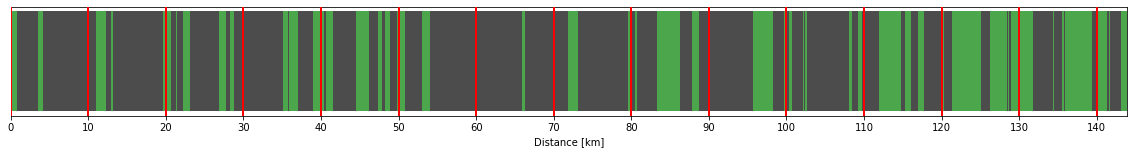

In [18]:
fig, ax = plt.subplots(figsize=(20,2))
plt.rc('font', size=20)
for idx, row in df.iterrows():
    x = [row['d0']/1000,row['d1']/1000]
    y = [1,1]
    if row['paved']:
        plt.plot(x,y,linewidth=100,color='black',solid_capstyle='butt',alpha=0.7)
    else:
        plt.plot(x,y,linewidth=100,color='green',solid_capstyle='butt',alpha=0.7)
plt.xticks(np.arange(0, 1000, step=10))
plt.yticks([])
plt.xlabel('Distance [km]')
plt.xlim(0,df['d1'].loc[df.shape[0]-1]/1000)
ax.set_axisbelow(False)
plt.grid(visible=True,axis='x',alpha=1,color='red',linewidth=2)

plt.show()

In [ ]:
# 

## Useful debug things

In [19]:
pd.set_option('display.max_rows', None)
# print(df.groupby(['first_highway','first_surface'])['first_tracktype'].value_counts(dropna=False))
# print(df.groupby(['first_highway','first_tracktype'])['first_surface'].value_counts(dropna=False))
print(df.groupby(['first_tracktype','first_surface'])['first_highway'].value_counts(dropna=False))
pd.reset_option('display.max_rows')

first_tracktype  first_surface    first_highway
grade1           asphalt          track              12
                 concrete         unclassified        9
                 grass            track              18
                                  unclassified       12
                 none             unclassified        2
                 paved            unclassified        6
grade2           fine_gravel      track              27
                 gravel           track               1
grade3           asphalt          unclassified       23
                 ground           path               36
                                  track               5
                 none             track              11
                                  service             2
grade4           compacted        track               2
                 grass_paver      track              58
                 none             track              15
grade5           grass            track               5


In [20]:
# grade3 asphalt unclassified
# mask_grade = df['first_tracktype']=='grade3'
# mask_surface = df['first_surface']=='asphalt'
# mask_highway = df['first_highway']=='unclassified'
# mask_tot = mask_grade & mask_surface & mask_highway

# bridleway
mask_highway = df['first_highway']=='bridleway'
mask_tot = mask_highway

# grade1
mask_grade = df['first_tracktype']=='grade1'
mask_tot = mask_grade

subset = df[mask_tot]

# Trying out ColorLine
# x = subset['x0'].values.tolist()
# y = subset['y0'].values.tolist()
# x.extend(df.tail(1)['x1'])
# y.extend(df.tail(1)['y1'])
# xy0 = list(zip(x,y))
# xy = [[coord[0],coord[1]] for coord in xy0]

# colormap = cm.LinearColormap(colors='black',vmin=0.25,vmax=0.75,index=[0.25,0.75])

mid = int(len(coords)/2)
chart = folium.Map(location=coords[mid], zoom_start=12, tiles="OpenStreetMap") # Map setup
    
# newline = folium.ColorLine(positions=xy, colors=colors, colormap=colormap, weight=3)
# newline.add_to(chart)
    
for idx, row in subset.iterrows():
    c = [[row['x0'],row['y0']],
         [row['x1'],row['y1']]]
    newline = folium.PolyLine(locations=c, color='red', weight=5, popup='None')
    newline.add_to(chart)

# # Render the map
filepath = "data/chart.html"
chart.save(filepath)
IFrame(filepath, width=1000, height=500)